In [1]:
!pip install keras tqdm

In [2]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

import keras.backend as K
from keras.layers import Activation, Input

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('classic')


Using TensorFlow backend.


### Loading data (Olivetti faces)

In [0]:
data_obj = fetch_olivetti_faces()

X_original = data_obj['data']

#binarize data
X = 1.0 * (X_original > X_original.mean())

y = data_obj['target']

indices = np.arange(len(y))

indices_train, indices_test, y_train, y_test = train_test_split(indices, y, stratify=y, test_size=0.1, random_state=0)

X_train = X[indices_train]
X_test = X[indices_test]

### RBM definitions

RBMs are undirected graphical models with the following structure ($h_i, v_j$ are binary):

<p align="center"><img src="http://40.media.tumblr.com/5e4a23b85f61e2aaeeb1188c2e35536a/tumblr_inline_npz2ev1m5Y1rnd3q0_540.png" /></p>

The joint probability is given by:
$$E(v, h) = vWh$$

$$P(v, h) = \frac{e^{-E(v, h)}}{Z}$$

($Z$ is a normalizing factor, $Z = \sum_{u, g}e^{-E(u, g)}$)

That means that $$P(h|v) = \prod_{i}P(h_i|v)$$ and consequently from the definition it follows that $$P(h_i = 1 \mid v) = \frac{1}{1 + exp((vW)_{i})}$$

RBMs are optimized using approximation to likelihood.

$$P(x) = \frac{\sum_{h}P(x, h)}{Z}$$

The algorithm that is used to approximate derivatives of log likelihood is called **contrastive divergence**, see for example [this link](http://deeplearning.net/tutorial/rbm.html).

In [0]:
def probabilities_from_other(W, other):
  """
  Get probabilities from hidden given visible or the other way around
  """
  energy = K.dot(other, W)
  return K.sigmoid(energy)


def sample_bernoulli(probas):
  uniform_samples = K.random_uniform(shape=K.shape(probas))
  bernoulli_samples = K.greater(
    probas,
    uniform_samples
  )
  return K.cast(bernoulli_samples, K.floatx())


def sample_from_other(W, other):
  """
  Sample hidden given visible or the other way around
  """
  proba = probabilities_from_other(W, other)
  return sample_bernoulli(proba)


def free_energy(W, visible):
  return - K.sum(
    K.softplus(K.dot(visible, W)),
    axis=-1
  )


def cd1_variables(W, visible):
  hidden0 = K.identity(
      probabilities_from_other(W, visible),
      name='hidden0')
  
  # suggested at Hinton's course - don't sample, use probabilities
  visible1 = K.identity(
      probabilities_from_other(K.transpose(W), hidden0),
      name='visible1')
  
  return hidden0, visible1


def cd1(W, visible):
  hidden0, visible1 = cd1_variables(W, visible)
  goodness0 = free_energy(W, visible)
  
  # we do this not to mess up gradient computation
  visible1_correct = K.stop_gradient(visible1)
  goodness1 = free_energy(W, visible1_correct)
  
  return K.mean(goodness0 - goodness1)

#### Plotting utils

In [0]:
def show_reconstruction(original, reconstructed, reconstructed_probabilities, howmany=5):
  original_faces = original.reshape(-1, 64, 64)
  reconstructed_faces = reconstructed.reshape(-1, 64, 64)
  reconstructed_probabilities_faces = reconstructed_probabilities.reshape(-1, 64, 64)
  
  for i in range(howmany):
    test_face = original_faces[i]
    reconstructed_face = reconstructed_faces[i]
    reconstructed_proba_face = reconstructed_probabilities_faces[i]
    
    plt.subplot(331)
    plt.imshow(reconstructed_proba_face, cmap='gray')
    plt.title('probabilities')
    plt.axis('off')
    
    plt.subplot(332)
    plt.imshow(test_face, cmap='gray')
    plt.title('original binarized')
    plt.axis('off')
    
    plt.subplot(333)
    plt.imshow(reconstructed_face, cmap='gray')
    plt.title('reconstructed binarized')
    plt.axis('off')
    
    plt.show()

In [0]:
n_visible = X_train.shape[1]
n_hidden = 500

W_in = K.variable(np.random.uniform(low=-2 / np.sqrt(n_hidden), high=2 / np.sqrt(n_hidden), size=(n_visible, n_hidden)))
visible_shape = (n_visible,)
visible_in = Input(shape=visible_shape)

cd = cd1(W_in, visible_in)

### RBM setup

In [0]:
lr = 0.02

[cd1_gradient] = K.gradients(cd, W_in)

train_op = K.function(
    inputs=[visible_in],
    outputs=[cd],
    updates=[
        K.update(W_in, W_in - lr * cd1_gradient)
    ]
)

In [8]:
print(K.eval(W_in))

[[ 0.00873202  0.03849424  0.01838287 ... -0.01758202 -0.04500517
   0.00104941]
 [-0.03392011 -0.02271221  0.00446685 ...  0.07842553 -0.04854118
   0.03168797]
 [ 0.01661493 -0.08764247 -0.00432434 ... -0.06936283 -0.08186441
  -0.04870317]
 ...
 [-0.06972324 -0.05617766  0.0522058  ...  0.03802041  0.07064375
  -0.06629859]
 [ 0.01711429 -0.05858089  0.04831056 ...  0.00885926 -0.07163104
   0.0577798 ]
 [ 0.04525103  0.05784644 -0.05484731 ... -0.05663916  0.0747067
   0.07731473]]


#### Run training

In [0]:
minibatch_size = 32
n_epochs = 500
_n_batches = int(round(X_train.shape[0] / minibatch_size))
log_n_epochs = 100
cd_values = []

In [10]:
%%time

for epoch in range(n_epochs):
  for i in range(_n_batches):
    minibatch_indices = np.random.randint(X_train.shape[0], size=minibatch_size)
    minibatch = X_train[minibatch_indices]
    [cd_value] = train_op([minibatch])
    cd_values.append(cd_value)
  if epoch % log_n_epochs == 0:
    print("epoch {}: cd={}".format(epoch, cd_value))

epoch 0: cd=21.746837615966797
epoch 100: cd=-366.0201416015625
epoch 200: cd=-386.8890380859375
epoch 300: cd=-360.4570617675781
epoch 400: cd=-365.78631591796875
CPU times: user 18.2 s, sys: 4.04 s, total: 22.2 s
Wall time: 18.8 s


### Plot training loss

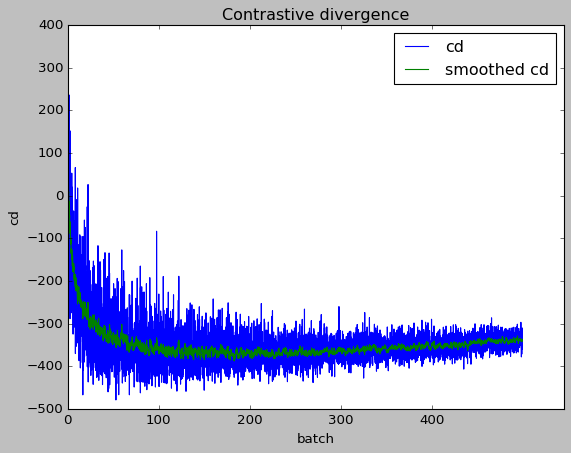

In [11]:
plt.title('Contrastive divergence')
plt.plot(cd_values, label='cd')
plt.plot(pd.Series(cd_values).ewm(alpha=0.1).mean(), label='smoothed cd')
plt.xlabel('batch')
plt.ylabel('cd')
plt.legend()
plt.xticks(np.arange(0, len(cd_values), step=_n_batches * log_n_epochs), log_n_epochs * np.arange(n_epochs))
plt.show()

In [12]:
print(K.eval(W_in))

[[ 0.01638047  0.01766394 -0.26993468 ... -0.0144898  -0.11980465
   0.00582062]
 [-0.03703118 -0.11152898 -0.15176685 ...  0.07469875 -0.13488093
  -0.0759492 ]
 [ 0.01673651 -0.15484396 -0.22757076 ... -0.07168945 -0.27438247
  -0.30581832]
 ...
 [-0.0169616   0.321547    0.2688429  ...  0.05101159 -0.01225831
   0.1865094 ]
 [ 0.06339182  0.3493807   0.07609389 ...  0.02130879 -0.08417124
   0.18170562]
 [ 0.08483775  0.49794874 -0.09952062 ... -0.03966472  0.12366326
   0.06393766]]


In [0]:
sample_hidden_from_visible = K.function(
  inputs=[visible_in],
  outputs=[
    probabilities_from_other(W_in, visible_in),
    sample_from_other(W_in, visible_in)
  ]
)

hidden_input = Input(shape=(n_hidden,))
sample_visible_from_hidden = K.function(
  inputs=[hidden_input],
  outputs=[
    probabilities_from_other(K.transpose(W_in), hidden_input),
    sample_from_other(K.transpose(W_in), hidden_input)]
)

In [0]:
[probabilities_visible_test, sampled_visible_test] = sample_visible_from_hidden(sample_hidden_from_visible([X_test]))
[probabilities_visible_train, sampled_visible_train] = sample_visible_from_hidden(sample_hidden_from_visible([X_train]))

### Show reconstructed faces

#### Reconstructed train faces

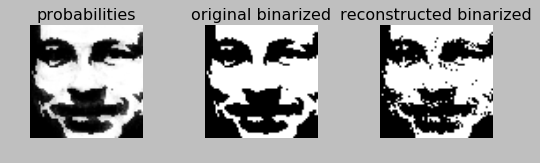

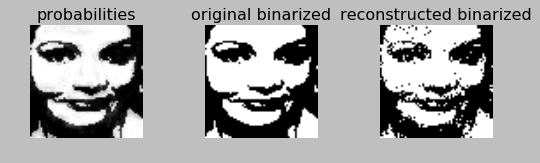

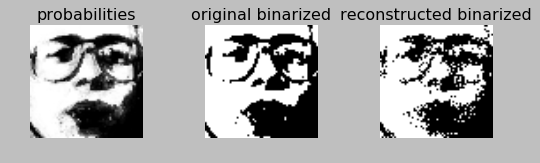

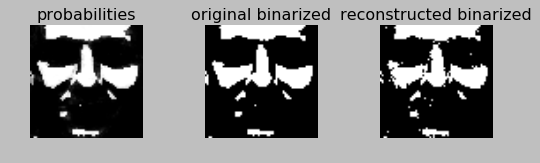

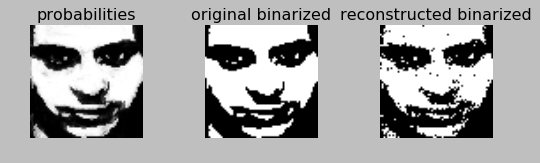

In [15]:
show_reconstruction(
    X_train,
    sampled_visible_train,
    probabilities_visible_train)

#### Reconstructed test faces

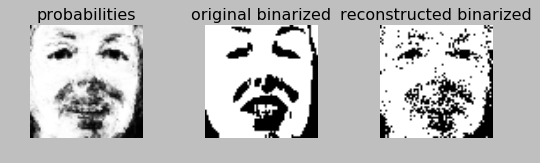

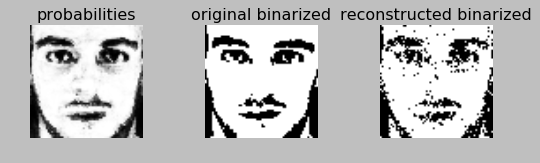

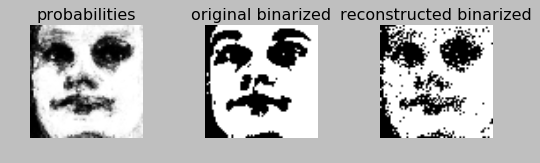

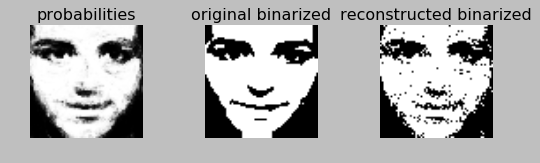

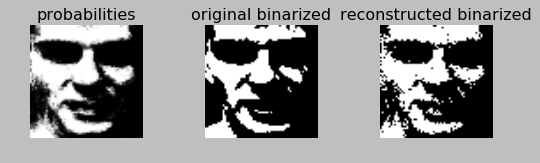

In [16]:
show_reconstruction(X_test, sampled_visible_test, probabilities_visible_test)

### Visualizing weights

Let's plot $P(v|h_i)$ for 100 $i$.

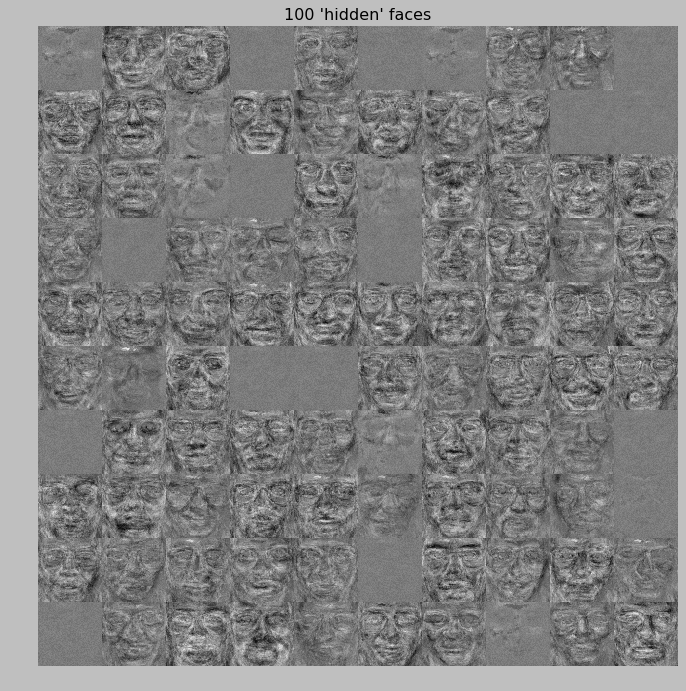

In [17]:
visible_probabilities_from_hidden = probabilities_from_other(
    K.transpose(W_in),
    hidden_input)

hidden_faces = visible_probabilities_from_hidden.eval(
    feed_dict={hidden_input: np.eye(n_hidden)},
    session=K.get_session()
)


side_length = 10
tiled_faces = np.vstack(
  [
      np.hstack(list(hidden_faces[i*side_length:(i+1)*side_length].reshape(-1, 64, 64)))
      for i in range(side_length)
  ]
)

plt.figure(figsize=(16, 10))
plt.title("""{} 'hidden' faces""".format(side_length **2))
plt.imshow(tiled_faces, cmap='gray')
plt.axis('off')
plt.show()